# Pretrained CNN-Based Image Colorization Net model

This colab file includes codes to train CNN model for Image Colorization task.
The CNN model combines the downsampling convolutional layers from pretrained model such as ResNet18, AlexNet, and VGG16 with customized upsampling layers.
Image data are trained using Lab channels where we use L channel as input and ab channels as target.

### Acknowledgement:
The model architecture is inspired by Luke Melas-Kyriazi's blog post $\textbf{Image Colorization with Convolutional Neural Networks}$: https://lukemelas.github.io/image-colorization.html. Parts of the codes are modified based on the codes the author shared in the blog post and Github: https://github.com/lukemelas/Automatic-Image-Colorization/.

In [ ]:
# Download and import libraries
!pip install torch torchvision matplotlib numpy scikit-image pillow==4.1.1

In [ ]:
!pip install https://github.com/CellProfiling/HPA-Cell-Segmentation/archive/master.zip

In [ ]:
!pip install Pillow==9.0.0

In [1]:
# unzip file
import zipfile
from google.colab import drive

drive.mount('/content/drive')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/231N project/tiny-imagenet-200 2.zip", 'r')
zip_ref.extractall(".")
zip_ref.close()

Mounted at /content/drive


In [2]:
import numpy as np
# For plotting
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion between RGB channel and Lab channel
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For CNN model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time

In [3]:
# Check if GPU is available
use_gpu = torch.cuda.is_available()

In [4]:
# Downsampling convolutional layers from Pretrained ResNet18 with customized upsampling layers
class ResColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ResColorizationNet, self).__init__()
    CONV_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract convolutional downsampling layers architecture
    self.conv_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(CONV_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.Sigmoid(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    conv_features = self.conv_resnet(input)

    # Upsample to get colors
    output = self.upsample(conv_features)
    return output

In [5]:
# Downsampling convolutional layers from Pretrained AlexNet with customized upsampling layers
class AlexColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(AlexColorizationNet, self).__init__()
    CONV_FEATURE_SIZE = 256

    ## First half: Alexnet
    alexnet = models.alexnet(num_classes=365) 
    # Extract convolutional downsampling layers architecture
    self.conv_alexnet = nn.Sequential(*list(alexnet.children())[0][:12])
    # Change first conv layer to accept single-channel (grayscale) input
    self.conv_alexnet[0].weight=nn.Parameter(self.conv_alexnet[0].weight.sum(dim=1).unsqueeze(1)) 

    ## Second half: Upsampling
    self.upsample = nn.Sequential(  
      nn.Conv2d(CONV_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=3),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=3),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      # nn.BatchNorm2d(32),
      # nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Sigmoid(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(2),
      nn.ReLU(),
      # nn.Upsample(scale_factor=2),
      nn.Conv2d(2, 2, kernel_size=8, stride=1, padding=0),
      nn.LeakyReLU()
    )

  def forward(self, input):

    # Pass input through AlexNet-gray to extract features
    conv_features = self.conv_alexnet(input)

    # Upsample to get colors
    output = self.upsample(conv_features)
    return output

In [6]:
# Downsampling convolutional layers from Pretrained VGG16 with customized upsampling layers
class VGGColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(VGGColorizationNet, self).__init__()
    CONV_FEATURE_SIZE = 512

    ## First half: ResNet
    vggnet = models.vgg16_bn(num_classes=365) 
    # Extract convolutional downsampling layers architecture
    self.conv_vggnet = nn.Sequential(*list(vggnet.children())[:2])
    # Change first conv layer to accept single-channel (grayscale) input
    self.conv_vggnet[0][0].weight=nn.Parameter(self.conv_vggnet[0][0].weight.sum(dim=1).unsqueeze(1)) 

    ## Second half: Upsampling
    self.upsample = nn.Sequential(
          # nn.ReLU(),
          nn.ConvTranspose2d(CONV_FEATURE_SIZE, 256, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
          nn.Sigmoid(),
          nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1),
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    conv_features = self.conv_vggnet(input)

    # Upsample to get colors
    output = self.upsample(conv_features)
    return output

In [7]:
# Customized dataloader to apply transformation and convert RGB images into Lab
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

In [8]:
# Training helper
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [9]:
# Model Validation
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg

In [10]:
# Model training
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))
  return losses.avg

In [11]:
# Choose which architecture to use
# candidate CNN structures
cnn_str = "ResNet"

In [39]:
# Initialize model
if cnn_str == "ResNet":
  model = ResColorizationNet()
elif cnn_str == "AlexNet":
  model = AlexColorizationNet()
elif cnn_str == "VGGNet":
  model = VGGColorizationNet()

In [40]:
# Pick optimizer and loss functions
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [41]:
if cnn_str == "AlexNet":
  resize = 227
else:
  resize = 224

# Training data loader
train_transforms = transforms.Compose([transforms.Resize(resize)])
train_imagefolder = GrayscaleImageFolder("/content/tiny-imagenet-200/train/", train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64,shuffle=False,sampler=torch.utils.data.SubsetRandomSampler(range(10000)))

# Validation  data loader
val_transforms = transforms.Compose([transforms.Resize(resize)])
val_imagefolder = GrayscaleImageFolder("/content/tiny-imagenet-200/val/" , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False,sampler=torch.utils.data.SubsetRandomSampler(range(1000)))


In [42]:
# Move model and loss function to GPU
use_gpu = True
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()

In [43]:
# Clean up previous created folders
shutil.rmtree('outputs/color')
shutil.rmtree('outputs/gray/')
shutil.rmtree('checkpoints/')

In [44]:
# Make folders and set parameters
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 10

In [ ]:
from matplotlib.image import NonUniformImage

# Train model
train_loss =[]
val_loss = []
best_model = None
for epoch in range(epochs):
  # Train for one epoch, then validate
  train_losses=train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_loader, model, criterion, save_images, epoch)
  scheduler.step()
  val_loss.append(losses)
  train_loss.append(train_losses)

  # update best model information
  if losses < best_losses:
    best_losses = losses
    best_model = model

# Save the best model
torch.save(best_model.state_dict(), 'checkpoints/{}-model-losses-{:.3f}.pth'.format(cnn_str,best_losses))


In [69]:
import pandas as pd
# output loss report
pd.DataFrame({'Epoch':pd.Series(range(epochs)),'Training Loss':pd.Series(train_loss),'Validation Loss':pd.Series(val_loss)}).to_csv("MSE.csv")

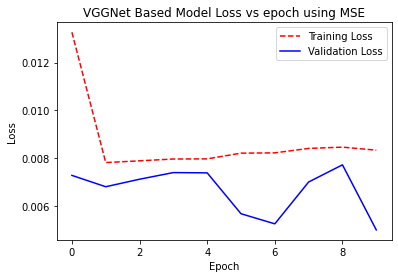

In [70]:
import matplotlib.pyplot as plt
plt.plot(range(epochs), train_loss, 'r--')
plt.plot(range(epochs), val_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(cnn_str+' Based Model Loss vs epoch using MSE')
plt.show();

In [ ]:
!zip -r /content/color.zip /content/outputs/color
!zip -r /content/gray.zip /content/outputs/gray
from google.colab import files
files.download("/content/color.zip")
files.download("/content/gray.zip")

In [ ]:
# Video colorization
def frame_as_rgb(grayscale_input, ab_input):
  color_image = torch.hstack((grayscale_input, ab_input)).squeeze(0) # combine channels
  color_image = color_image.permute(1, 2, 0)  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128
  color_image = lab2rgb(color_image.cpu().detach().numpy().astype(np.float64))
  return color_image


In [ ]:
cap = cv2.VideoCapture("/content/drive/MyDrive/mickymouse.mp4")
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
# Get original video features
FPS = cap.get(cv2.CAP_PROP_FPS) #number of frames/photos taken per second by the camera
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) #check resolution
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# setup video writer
out = cv2.VideoWriter("/content/mickymouse_colorized.mp4", fourcc, FPS, (w,h), True)

f=0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
os.makedirs('/content/video_frame/frame/', exist_ok=True)

In [ ]:
# Load trained model
# Initialize model
if cnn_str == "ResNet":
  model = ResColorizationNet()
elif cnn_str == "AlexNet":
  model = AlexColorizationNet()
elif cnn_str == "VGGNet":
  model = VGGColorizationNet()
use_gpu = True
if use_gpu: 
  model = model.cuda()
model.load_state_dict(torch.load("/content/drive/MyDrive/model-epoch-8-losses-0.047.pth",\
                                         map_location=device)) # load appropriate model

In [ ]:
model.eval()

In [ ]:
trans = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(resize)])

In [ ]:
from google.colab.patches import cv2_imshow
interim_plot=False

In [ ]:
while cap.isOpened():

  f+=1
  success, frame = cap.read()
  if not success:
    print("Finish reading all frames!")
    break
  else:
    print("Current on frame {}".format(f))
    cv2.imwrite("/content/video_frame/frame/temp.jpg",cv2.resize(frame,(256,256)))
    img = GrayscaleImageFolder("/content/video_frame/",trans)
    img_loader = torch.utils.data.DataLoader(img,batch_size=1)
    for i, (img_gray, _, _) in enumerate(img_loader):
      output_ab = model(img_gray.to(device)) # apply model to predict single frame
      colored_frame = frame_as_rgb(img_gray.to(device), output_ab.to(device))*255
      if interim_plot: # Interim frames checking
        cv2_imshow(colored_frame)
      out.write(cv2.resize(colored_frame,(w,h)).astype("uint8"))

  k = cv2.waitKey(30) & 0xFF #need to open the window(show the photo) in order to close the window
  if k==ord('q'): #the q must be entered at the camera window instead of the terminal
    break

cap.release()
out.release()
cv2.destroyAllWindows()